# Binary Classification with Lens

In [1]:
from credoai.lens import Lens, CredoModel, CredoData, CredoGovernance
from credoai.assessment import FairnessBaseAssessment, DatasetAssessment



Failed to import tensorflow. Please note that tensorflow is not installed by default when you install tensorflow_hub. This is so that users can decide which tensorflow package to use. To use tensorflow_hub, please install a current version of tensorflow by following the instructions at https://tensorflow.org/install and https://tensorflow.org/hub/installation.




## Contents

1. [What is Covered](#What-is-Covered)
1. [Introduction](#Introduction)
1. [The UCI Credit-card Default Dataset](#The-UCI-Credit-Card-Default-Dataset)
1. [Model training](#Train-the-model)
1. [Binary Classification with Lens](#Running-Lens)


## What is Covered

* **Domain:**
  * Finance (loan decisions). The data is semisynthetic to create a simple example of disparities in FPR and FNR.

* **ML task:**
  * Binary classification.

## Introduction

In this notebook, we consider a scenario where algorithmic tools are deployed to predict the likelihood that an applicant will default on a credit card loan. The notebook emulates the problem presented in this [white paper](https://www.microsoft.com/en-us/research/uploads/prod/2020/09/Fairlearn-EY_WhitePaper-2020-09-22.pdf) in collaboration with EY.

Due to data privacy, we do not use the data from the white paper. Instead, we use the [UCI Credit-card default dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients), a toy dataset reflecting credit-card defaults in Taiwan, as a substitute dataset to replicate the desired workflow. To make this dataset applicable to our problem, we introduce a synthetic feature that is highly predictive for applicants defined as "female" in terms of the "gender" feature, but is uninformative for applicants defined as "male".

We train an algorithm on this dataset and show the model has a higher false-positive rate as well as a higher false-negative rate for the "male" group than for the "female" group using the Credo Fairness Module.

In [2]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint
# Data processing
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import GradientBoostingClassifier as gbc

# data
from credoai.data import fetch_creditdefault

## Prepare Data
### The UCI Credit-Card Default Dataset

The UCI dataset contains data on 30,000 clients and their credit card transactions at a bank in Taiwan. In addition to static client features, the dataset contains the history of credit card bill payments between April and September 2005, as well as the balance limit of the client's credit card. The target is whether the client will default on a card payment in the following month, October 2005. A model trained on this data could be used, in part, to determine whether a client is eligible for another loan or a credit increase.

In [3]:
data = fetch_creditdefault()
dataset = pd.concat([data['data'], data['target']], axis=1)
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000.0,male,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,male,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,male,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,male,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,female,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Dataset columns:

* `LIMIT_BAL`: credit card limit, will be replaced by a synthetic feature
* `gender, EDUCATION, MARRIAGE, AGE`: client demographic features
* `BILL_AMT[1-6]`: amount on bill statement for April-September
* `PAY_AMT[1-6]`: payment amount for April-September
* `default payment next month`: target, whether the client defaulted the following month

In [4]:
# Extract the sensitive feature
gender = dataset["SEX"]
# Extract the target
Y = dataset["default payment next month"].astype(int)

### Introduce a Synthetic Feature

We manipulate the balance-limit feature `LIMIT_BAL` to make it highly predictive for the "female" group but not for the "male" group. Specifically, we set this up, so that a lower credit limit indicates that a female client is less likely to default, but provides no information on a male client's probability of default.

In [5]:
dist_scale = 0.5
np.random.seed(12345)
# Make 'LIMIT_BAL' informative of the target
dataset['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, size=dataset.shape[0])
# But then make it uninformative for the male clients
dataset.loc[gender=="male", 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, size=dataset[gender=="male"].shape[0])

In [6]:
dataset['LIMIT_BAL'][(gender==1) & (Y==0)]

Series([], Name: LIMIT_BAL, dtype: float64)

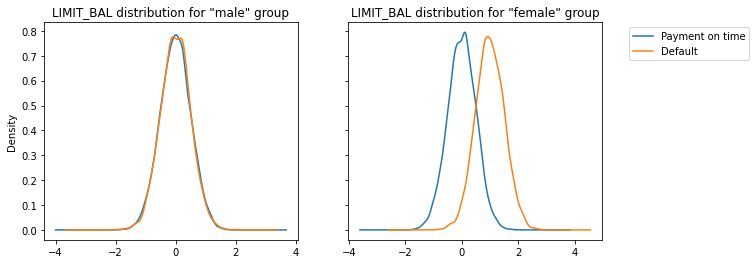

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# Plot distribution of LIMIT_BAL for men
dataset['LIMIT_BAL'][(gender=="male") & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax1, 
                                           title="LIMIT_BAL distribution for \"male\" group")
dataset['LIMIT_BAL'][(gender=="male") & (Y==1)].plot(kind='kde', label="Default", ax=ax1)
# Plot distribution of LIMIT_BAL for women
dataset['LIMIT_BAL'][(gender=="female") & (Y==0)].plot(kind='kde', label="Payment on time", ax=ax2, 
                                           legend=True, title="LIMIT_BAL distribution for \"female\" group")
dataset['LIMIT_BAL'][(gender=="female") & (Y==1)].plot(kind='kde', label="Default", ax=ax2, 
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
plt.show()

Note in the above figures that the new `LIMIT_BAL` feature is indeed highly predictive for the "female" group, but not for the "male" group.

In [8]:
# Train-test split
X_train, X_test, Y_train, Y_test, gender_train, gender_test = train_test_split(
    dataset.drop(columns=['SEX', 'default payment next month']), 
    Y, 
    gender, 
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

## Train the model

This is a "fairness unaware" model. This means it is trained with no consideration to fairness or protected attributes.

We train an out-of-the-box `gradient boosted classifier` model on the modified data and assess several fairness metrics. 

In [9]:
model = gbc()
model.fit(X_train, Y_train)

GradientBoostingClassifier()

In [10]:
# Scores on test set
test_scores = model.predict_proba(X_test)[:, 1]

In [11]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

## Running Lens

Governance credentials allow Lens to connect directly to the Credo AI Governance Platform. One important function of this connection is to get the "Alignment Spec" - the set of instructions for how the model should be assessed. 

Another function is to export assessment results to be incorporated in your AI Governance operations.

For this demo, we assume you do _not_ have access to Credo AI's governance platform. In this case, the Alignment Spec must be created manually.

In [21]:
"""
# governance information
# used to connect to Credo AI Alignment
# uncomment and fill in to see how
# governance -> automatic alignment spec
# incorporation
gov = CredoGovernance(
    ai_solution_id = "{example_id}",
    model_id = "{example_id}",
    data_id = ""
)
"""
alignment_spec = {
    'FairnessBase': {'metrics': ['recall_score', 'demographic_parity_ratio']}
}

In [22]:
assessment_data = CredoData(
    name='UCI_dataset', 
    X=X_test, 
    y=Y_test, 
    sensitive_features=gender_test,
    metadata={'stage': 'validation'})

In [23]:
# The model config is a dictionary that defines the 
# functions that will be used for assessment. 
# These functions nclude functions that take in data,
# as well as functions that reveal internal aspects
# of the model (e.g., embeddings, feature importances)

# the config is then passed to CredoModel,
# a wrapper that instantiates the functionality
# defined in the config
model_config = {'pred_fun': model.predict,
                'prob_fun': model.predict_proba}
credo_model = CredoModel(name='model_test', 
                         model_config=model_config)

# If the model config can be inferred directly from 
# the model (as in the second example above),
# you can pass the model straight
# to CredoModel as the model_config
credo_model = CredoModel(name='test', 
                         model=model)

In [24]:
lens = Lens(spec=alignment_spec,
            assessments=[FairnessBaseAssessment()],
            model=credo_model,
            data=assessment_data
            )

In [25]:
assessment_results = lens.run_assessments(export=False)
fairness_results = assessment_results['FairnessBase']

In [26]:
# the Fairness Assesssent returns two dataframes
fairness_results.keys()

dict_keys(['fairness', 'disaggregated_results'])

In [27]:
fairness_results['fairness']

,value,kind
metric_type,,
demographic_parity_ratio,0.49197,parity


In [28]:
fairness_results['disaggregated_results']

""


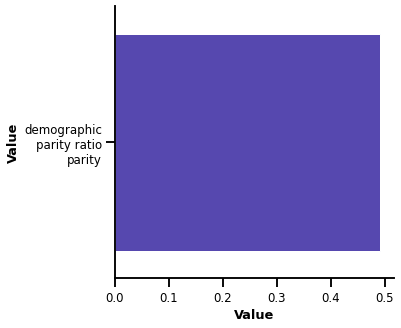

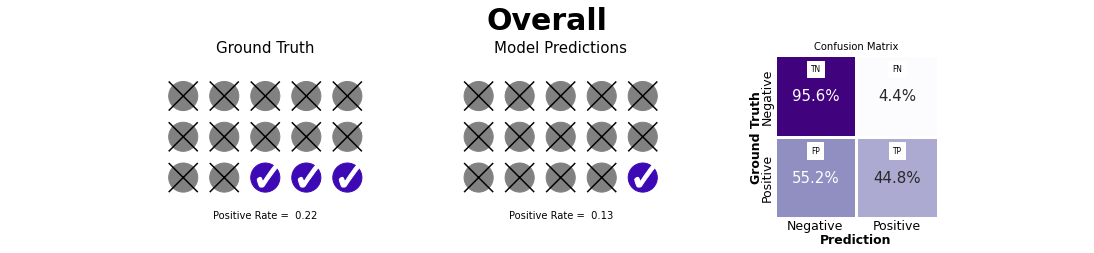

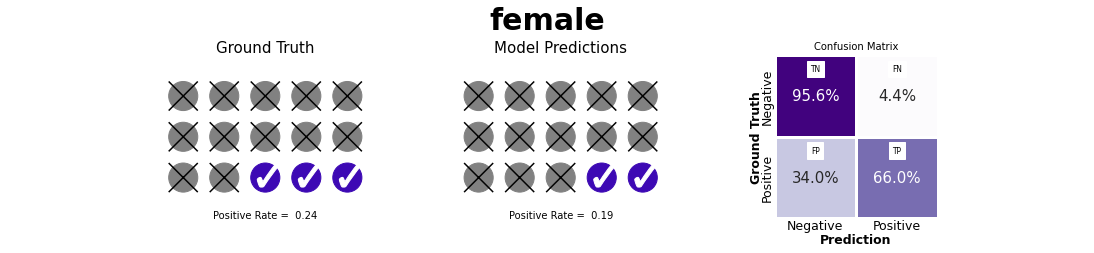

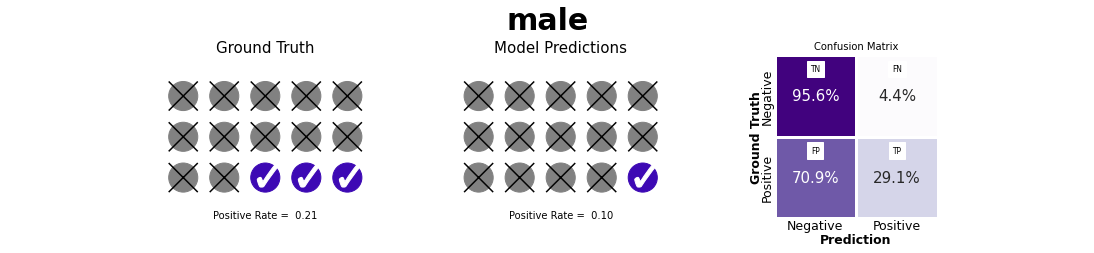

In [29]:
report = lens.create_reports()